<u>Problem Description</u>


The data I am utilizing was created by the Major Atmospheric Gamma Imaging Cherenkov Telescope (MAGIC) project. This was provided to Kaggle by user ABHINAND, where it was obtained for use in this project. The data are a simulation of particle showers released by gamma rays. These showers release Cherenkov radiation which is ultimately recorded by MAGIC through photons. MAGIC then can record certain qualities of the photons, such as their major axis of ellipse, distance from origin to center of ellipse, and ratio of highest pixel over the size of all pixels (pixels in the photon). Parameters such as these and others are used to determine whether a particle in the shower is in fact a gamma particle (the signals we are searching for, consider this our positive value) and hadron particles (the background or negative values in our case). As stated on Kaggle, classifying a false positive with these data as I have defined them has more consequences than a false negative. Thus, simple accuracy is not a good judge of the classifiers, with ABHINAND suggesting the use of an ROC curve, which I implement. 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import time

In [15]:
##EDA
data = pd.read_csv('telescope_data.csv')
data.drop(columns=data.columns[0], inplace=True)

#NA's
count = 0
for i in range(len(data.columns)):
    if data[data.columns[i]].isna().sum() > 0:
        print(data.columns[i])
    else:
        count+=1
if count == len(data.columns):
    print('No explicit null values in dataset.')


#Converting binary class labels to 0 and 1
data['class'] = np.where(data['class'] == 'g', 1, 0)
#Train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='class'), data['class'], test_size=0.2, random_state=42)

No explicit null values in dataset.


In [3]:
alt.data_transformers.disable_max_rows()
charts = []
for i in range(len(data.columns) - 1):
    chart_i = alt.Chart(data.reset_index()).mark_circle(size=60).encode(
        x='index',
        y=data.columns[i],
        color='class'
    ).interactive()
    charts.append(chart_i)
charts[0]&charts[1]&charts[2]&charts[3]&charts[4]&charts[5]&charts[6]&charts[7]&charts[8]&charts[9]



alt.VConcatChart(...)

In [10]:
##Modeling
models = [
    svm.SVC(kernel='poly', C=1.0, probability=True), 
    DecisionTreeClassifier(max_features=4), 
    RandomForestClassifier(n_estimators=30, max_features='sqrt'), 
    KNeighborsClassifier(n_neighbors=9, algorithm='ball_tree', p=2)
]
models_lab = [
    'Support Vector Machine', 'Decision Tree', 'Random Forest', 'K Nearest Neighbors Classifier'
]
model_dict = {}
for val in models:
    model_dict[val] = {}
    start = time.process_time()
    clf = val.fit(X_train, y_train)
    predict = clf.predict(X_test)
    timer = time.process_time() - start
    model_dict[val].update({'Accuracy': accuracy_score(y_test, predict)})
    model_dict[val].update({'Recall': recall_score(y_test, predict)})
    model_dict[val].update({'Precision': precision_score(y_test, predict)})
    model_dict[val].update({'F1 Score': f1_score(y_test, predict)})
    model_dict[val].update({'Time (s)': timer})
    model_dict[val].update({'Predicted': val.predict_proba(X_test)})

In [11]:
##Evaluation
for val in models:
    print(val)
    print('Test Accuracy:', model_dict[val]['Accuracy'])
    print('Test Recall:', model_dict[val]['Recall'])
    print('Test Precision:',model_dict[val]['Precision'])
    print('Training and Predict Time (s):',model_dict[val]['Time (s)'])
    print('\n')
y = []
evals = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'Time (s)', 'Predicted']
models_row = []
for val in models:
    for i in range(len(evals)):
        y.append(model_dict[val][evals[i]])
        models_row.append(val)
acc = []
rec = []
prec = []
f1 = []
times = []
predict = []

for i in range(len(y)):
    if i % 6 == 0:
        acc.append(y[i])
    elif i % 6 == 1:
        rec.append(y[i])
    elif i % 6 == 2:
        prec.append(y[i])
    elif i % 6 == 3:
        f1.append(y[i])
    elif i % 6 == 4:
        times.append(y[i])
    elif i % 6 == 5:
        predict.append(y[i])

SVC(kernel='poly', probability=True)
Test Accuracy: 0.8162460567823344
Test Recall: 0.9621951219512195
Test Precision: 0.7961654894046418
Training and Predict Time (s): 36.063705999999996


DecisionTreeClassifier(max_features=4)
Test Accuracy: 0.8088853838065194
Test Recall: 0.8532520325203252
Test Precision: 0.8515212981744422
Training and Predict Time (s): 0.09849999999998715


RandomForestClassifier(max_features='sqrt', n_estimators=30)
Test Accuracy: 0.8719768664563617
Test Recall: 0.9247967479674797
Test Precision: 0.8828094683740784
Training and Predict Time (s): 1.4823199999999872


KNeighborsClassifier(algorithm='ball_tree', n_neighbors=9)
Test Accuracy: 0.8222923238696109
Test Recall: 0.9451219512195121
Test Precision: 0.811235170969993
Training and Predict Time (s): 0.9085560000000044




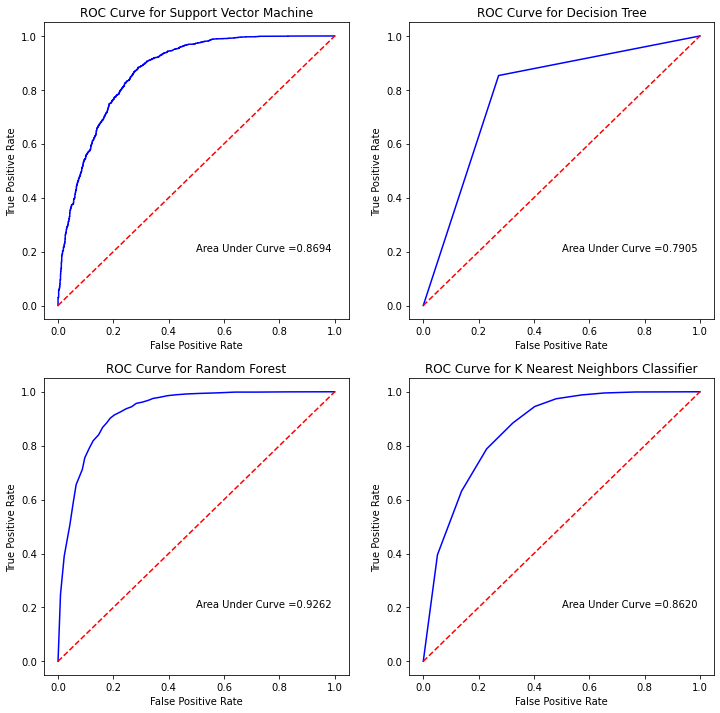

In [12]:
fig, axs = plt.subplots(2, 2)
fig.set_figheight(12)
fig.set_figwidth(12)
for i in range(len(predict)):
    fpr, tpr, th = roc_curve(y_test, predict[i][:, 1])
    auc = roc_auc_score(y_test, predict[i][:, 1])
    if i == 0:
        axs[0, 0].plot(fpr, tpr, '-b')
        axs[0,0].plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), '--r')
        axs[0,0].set_xlabel('False Positive Rate')
        axs[0,0].set_ylabel('True Positive Rate')
        axs[0,0].text(0.5, 0.2, 'Area Under Curve =' + '{:.4f}'.format(auc))
        axs[0,0].set_title('ROC Curve for ' + models_lab[i])
    elif i == 1:
        axs[0, 1].plot(fpr, tpr, '-b')
        axs[0,1].plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), '--r')
        axs[0,1].set_xlabel('False Positive Rate')
        axs[0,1].set_ylabel('True Positive Rate')
        axs[0,1].text(0.5, 0.2, 'Area Under Curve =' + '{:.4f}'.format(auc))
        axs[0,1].set_title('ROC Curve for ' + models_lab[i])
    elif i == 2:
        axs[1, 0].plot(fpr, tpr, '-b')
        axs[1,0].plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), '--r')
        axs[1,0].set_xlabel('False Positive Rate')
        axs[1,0].set_ylabel('True Positive Rate')
        axs[1,0].text(0.5, 0.2, 'Area Under Curve =' + '{:.4f}'.format(auc))
        axs[1,0].set_title('ROC Curve for ' + models_lab[i])
    else:
        axs[1, 1].plot(fpr, tpr, '-b')
        axs[1,1].plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), '--r')
        axs[1,1].set_xlabel('False Positive Rate')
        axs[1,1].set_ylabel('True Positive Rate')
        axs[1,1].text(0.5, 0.2, 'Area Under Curve =' + '{:.4f}'.format(auc))
        axs[1,1].set_title('ROC Curve for ' + models_lab[i])
plt.show()

In [9]:
d = {'Model': models_lab, 'Accuracy': acc, 'Recall': rec, 'Precision': prec, 'F1 Score': f1, 'Time': times}
df = pd.DataFrame(data=d)
click = alt.selection_multi(encodings=['color'])

accuracy = alt.Chart(df).mark_bar().encode(
    x='Model:O',
    y='Accuracy:Q',
    color='Model:N',
).add_selection(
    click
)
recall = alt.Chart(df).mark_bar().encode(
    x='Model:O',
    y='Recall:Q',
    color='Model:N'
)
precision = alt.Chart(df).mark_bar().encode(
    x='Model:O',
    y='Precision:Q',
    color='Model:N'
)
f1_chart = alt.Chart(df).mark_bar().encode(
    x='Model:O',
    y='F1 Score:Q',
    color='Model:N'
)
time_chart = alt.Chart(df).mark_bar().encode(
    x='Model:O',
    y='Time:Q',
    color='Model:N'
)
accuracy | recall | precision | f1_chart | time_chart

alt.HConcatChart(...)

<u> Conclusion </u>

The dataset from the Major Atmospheric Gamma Imaging Cherenkov Telescope project is composed of 12 columns (one of which is a column of indices and was dropped for this project) and 19020 rows where each row is an instance from the simulation. Each of these fall in a binary class which is also provided, meaning we will be able to utilize supervised machine learning techniques. 

My work on the project started with exploratory data analytics (EDA). I began by checking for null values among all columns which there were none of. I then converted the binary class labels from strings to 1's and 0's (gamma, and hadron particles, respectively) using numpy's where method, checked a quick overview of the data, and then split the data into training and test sets. For this, I used a test size of 0.2 and utilized sklearn. Then as my final form of EDA, I utilized the python library Altair to visualize the data for each column as split along whether the row was classified one or zero. From this, I was able to see whether each column had stark differences among the binary classes, where five columns seemed to have such differences.

After my EDA, I began modeling. After what we discussed in this class, I decided to utilize the suervised learning methods of support vector machine, decision tree classifier, random forest, and k-nearest neighbors. With these I adjusted hyperparameters for each method and then measured and recorded their accuracy, recall, precision, ROC curve, and f1 score on the test set, and then the time it took for each method to fit to the training data and then predict on the test data. This resulted in random forest giving the optimal all-around performance metrics (particularly in ROC which was of import in this problem), while having a proficient run-time (though it was still the 3rd slowest out of 4). These results were then charted in altair as bar charts for a visual representation. From the charts we can see that support vector machine's runtime stands as an outlier having a runtime greater than 9 seconds, though it did have proficient performance.

[github repo](https://github.com/skembr01/intro_machine_learning_final)

https://github.com/skembr01/intro_machine_learning_final